<a href="https://colab.research.google.com/github/ArmanZak/PRODIGY_GA_TASKS/blob/main/PRODIGY_GA_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving dog_images.jpeg to dog_images.jpeg


Saving Pablo-Picasso-Portrait-of-Mateu-Fernández-de-Soto--1024x822.jpg to Pablo-Picasso-Portrait-of-Mateu-Fernández-de-Soto--1024x822.jpg
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


Iteration 0, Loss: 86.31218719482422
Iteration 50, Loss: 536.4874877929688
Iteration 100, Loss: 528.0211181640625
Iteration 150, Loss: 523.7706298828125
Iteration 200, Loss: 520.056396484375


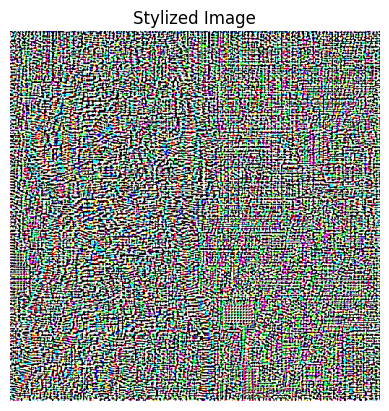

In [2]:
# 📦 Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time
import os

from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# 📥 Upload images
from google.colab import files
uploaded = files.upload()
content_path = list(uploaded.keys())[0]

uploaded = files.upload()
style_path = list(uploaded.keys())[0]

# 📐 Image preprocessing
def load_and_process_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (512, 512))
    img = img[tf.newaxis, :]
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    x = x.reshape((512, 512, 3))
    x = np.clip(x, 0, 1)
    return x

# 🎨 Style & content layer definitions
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    model = Model([vgg.input], outputs)
    return model

def get_content_and_style_representations(model, content_img, style_img):
    style_outputs = model(style_img)
    content_outputs = model(content_img)

    style_features = [style_layer for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

# 🚀 Run style transfer
def run_style_transfer(content_path, style_path, num_iterations=250,
                       content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    style_features, content_features = get_content_and_style_representations(model, content_image, style_image)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.keras.optimizers.Adam(learning_rate=5.0)

    best_loss, best_img = float('inf'), None

    @tf.function()
    def compute_grads():
        with tf.GradientTape() as tape:
            outputs = model(init_image)
            style_output_features = outputs[:num_style_layers]
            content_output_features = outputs[num_style_layers:]
            style_score = 0
            content_score = 0

            for target_style, comb_style in zip(gram_style_features, style_output_features):
                style_score += tf.reduce_mean(tf.square(gram_matrix(comb_style) - target_style))

            for target_content, comb_content in zip(content_features, content_output_features):
                content_score += tf.reduce_mean(tf.square(comb_content - target_content))

            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
        grad = tape.gradient(loss, init_image)
        return grad, loss

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    for i in range(num_iterations):
        grads, loss = compute_grads()
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, clip_value_min=0.0, clip_value_max=1.0)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()

        if i % 50 == 0:
            print(f"Iteration {i}, Loss: {loss}")

    return best_img, best_loss

# 🧠 Run the transfer
final_img, final_loss = run_style_transfer(content_path, style_path, num_iterations=250)

# 📸 Display the result
plt.imshow(deprocess_img(final_img))
plt.title("Stylized Image")
plt.axis('off')
plt.show()
